# 2 layer synthetic inversion, with a regional field

Here we try to recover the true Layer 2 topography with a gravity inversion. The gravity data is the forward gravity of Layer 1, 2, and 3, representing a perfect gravity survey with no error. The inputs into the inversion are a full resolution Layer 1, representing the `ice surface`, a low resolution Layer 2, representing the `bed topography`, which has been created through the random sampling and grid of 30 contraint points. In an Antarctic setting, these points represent single seismic survey locations which image the elevation of Layer 2. While not included as a layer in the inversion, the forward gravity of Layer3 is included in the observed gravity. This field represents the regional gravity signal from factors such as long wavelength crustal thickness variations. 

import packages

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth 

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


# Set region and parameters

Use the same regions and parameters as `synthetic_model_simple_with_regional.ipynb`

In [3]:
# set grid parameters
spacing = 1e3
registration = "g"
inversion_region = [0, 80e3, 0, 60e3]

# set gravity observation parameters
grav_observation_height = 1000
grav_spacing = 1e3  # true spacing was 2km for sampled, 1km for full res

buffer_region = utils.alter_region(
    inversion_region,
    buffer=12e3,
)[1]


print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [0, 80000.0, 0, 60000.0]
buffer region =  [-12000, 92000, -12000, 72000]


# Load data

## topographic layers
* 3 full resolution synthetic layers
* low resolution layer 2

In [4]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1_simple.zarr").z

true_layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2_simple.zarr").z

starting_layer2 = xr.open_zarr(
    "../synthetic_data/synthetic_starting_layer2_simple.zarr"
)["z"]

layer3 = xr.open_zarr("../synthetic_data/synthetic_layer3_simple.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
true_layer2 = true_layer2.astype(np.float64)
starting_layer2 = starting_layer2.astype(np.float64)
layer3 = layer3.astype(np.float64)

# resample all layer to same spacing / extent
layer1 = fetch.resample_grid(
    layer1,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
true_layer2 = fetch.resample_grid(
    true_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
starting_layer2 = fetch.resample_grid(
    starting_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
layer3 = fetch.resample_grid(
    layer3,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)

print(utils.get_grid_info(starting_layer2))
starting_layer2

/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


returning original grid
returning original grid
returning original grid
returning original grid
(1000.0, [-12000.0, 92000.0, -12000.0, 72000.0], -932.234313965, -540.887084961, 'g')


<xarray.DataArray 'z' (y: 85, x: 105)>
dask.array<astype, shape=(85, 105), dtype=float64, chunksize=(85, 105), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -1.2e+04 -1.1e+04 -1e+04 ... 9e+04 9.1e+04 9.2e+04
  * y        (y) float64 -1.2e+04 -1.1e+04 -1e+04 ... 7e+04 7.1e+04 7.2e+04
Attributes:
    actual_range:  [-932.2343139648438, -540.8870849609375]
    long_name:     z

## gravity data
* full resolution gravity grid
* gravity observations

In [5]:
# load resolution gravity grid
synthetic_gravity = xr.open_zarr("../synthetic_data/synthetic_forward_grav_simple_with_regional.zarr")

# use full grid
grav = vd.grid_to_table(synthetic_gravity.astype(np.float64))

# set standard column names
grav = grav.rename(columns={'forward_total':'Gobs'})

# remove other columns
grav = grav[["x", "y", "Gobs", "z"]]

# center gravity around 0
grav.Gobs -= grav.Gobs.mean()

print(f"gravity: {len(grav)} points")
print(f"gravity avg. elevation: {int(np.nanmean(grav.z))}")

# grid the observed gravity
Gobs = grav.set_index(["y", "x"]).to_xarray().Gobs

grav

gravity: 4941 points
gravity avg. elevation: 1000


,x,y,Gobs,z
0,0.0,0.0,13.529403,1000.0
1,1000.0,0.0,13.007873,1000.0
2,2000.0,0.0,12.486292,1000.0
3,3000.0,0.0,11.966150,1000.0
4,4000.0,0.0,11.448589,1000.0
...,...,...,...,...
4936,76000.0,60000.0,4.327390,1000.0
4937,77000.0,60000.0,4.407698,1000.0
4938,78000.0,60000.0,4.490917,1000.0
4939,79000.0,60000.0,4.576358,1000.0


## constraint points

In [6]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints_simple.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all,
    inversion_region,
)

print(f"bathymetry control points:{len(constraint_points)}")

bathymetry control points:30


## plot inputs

returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


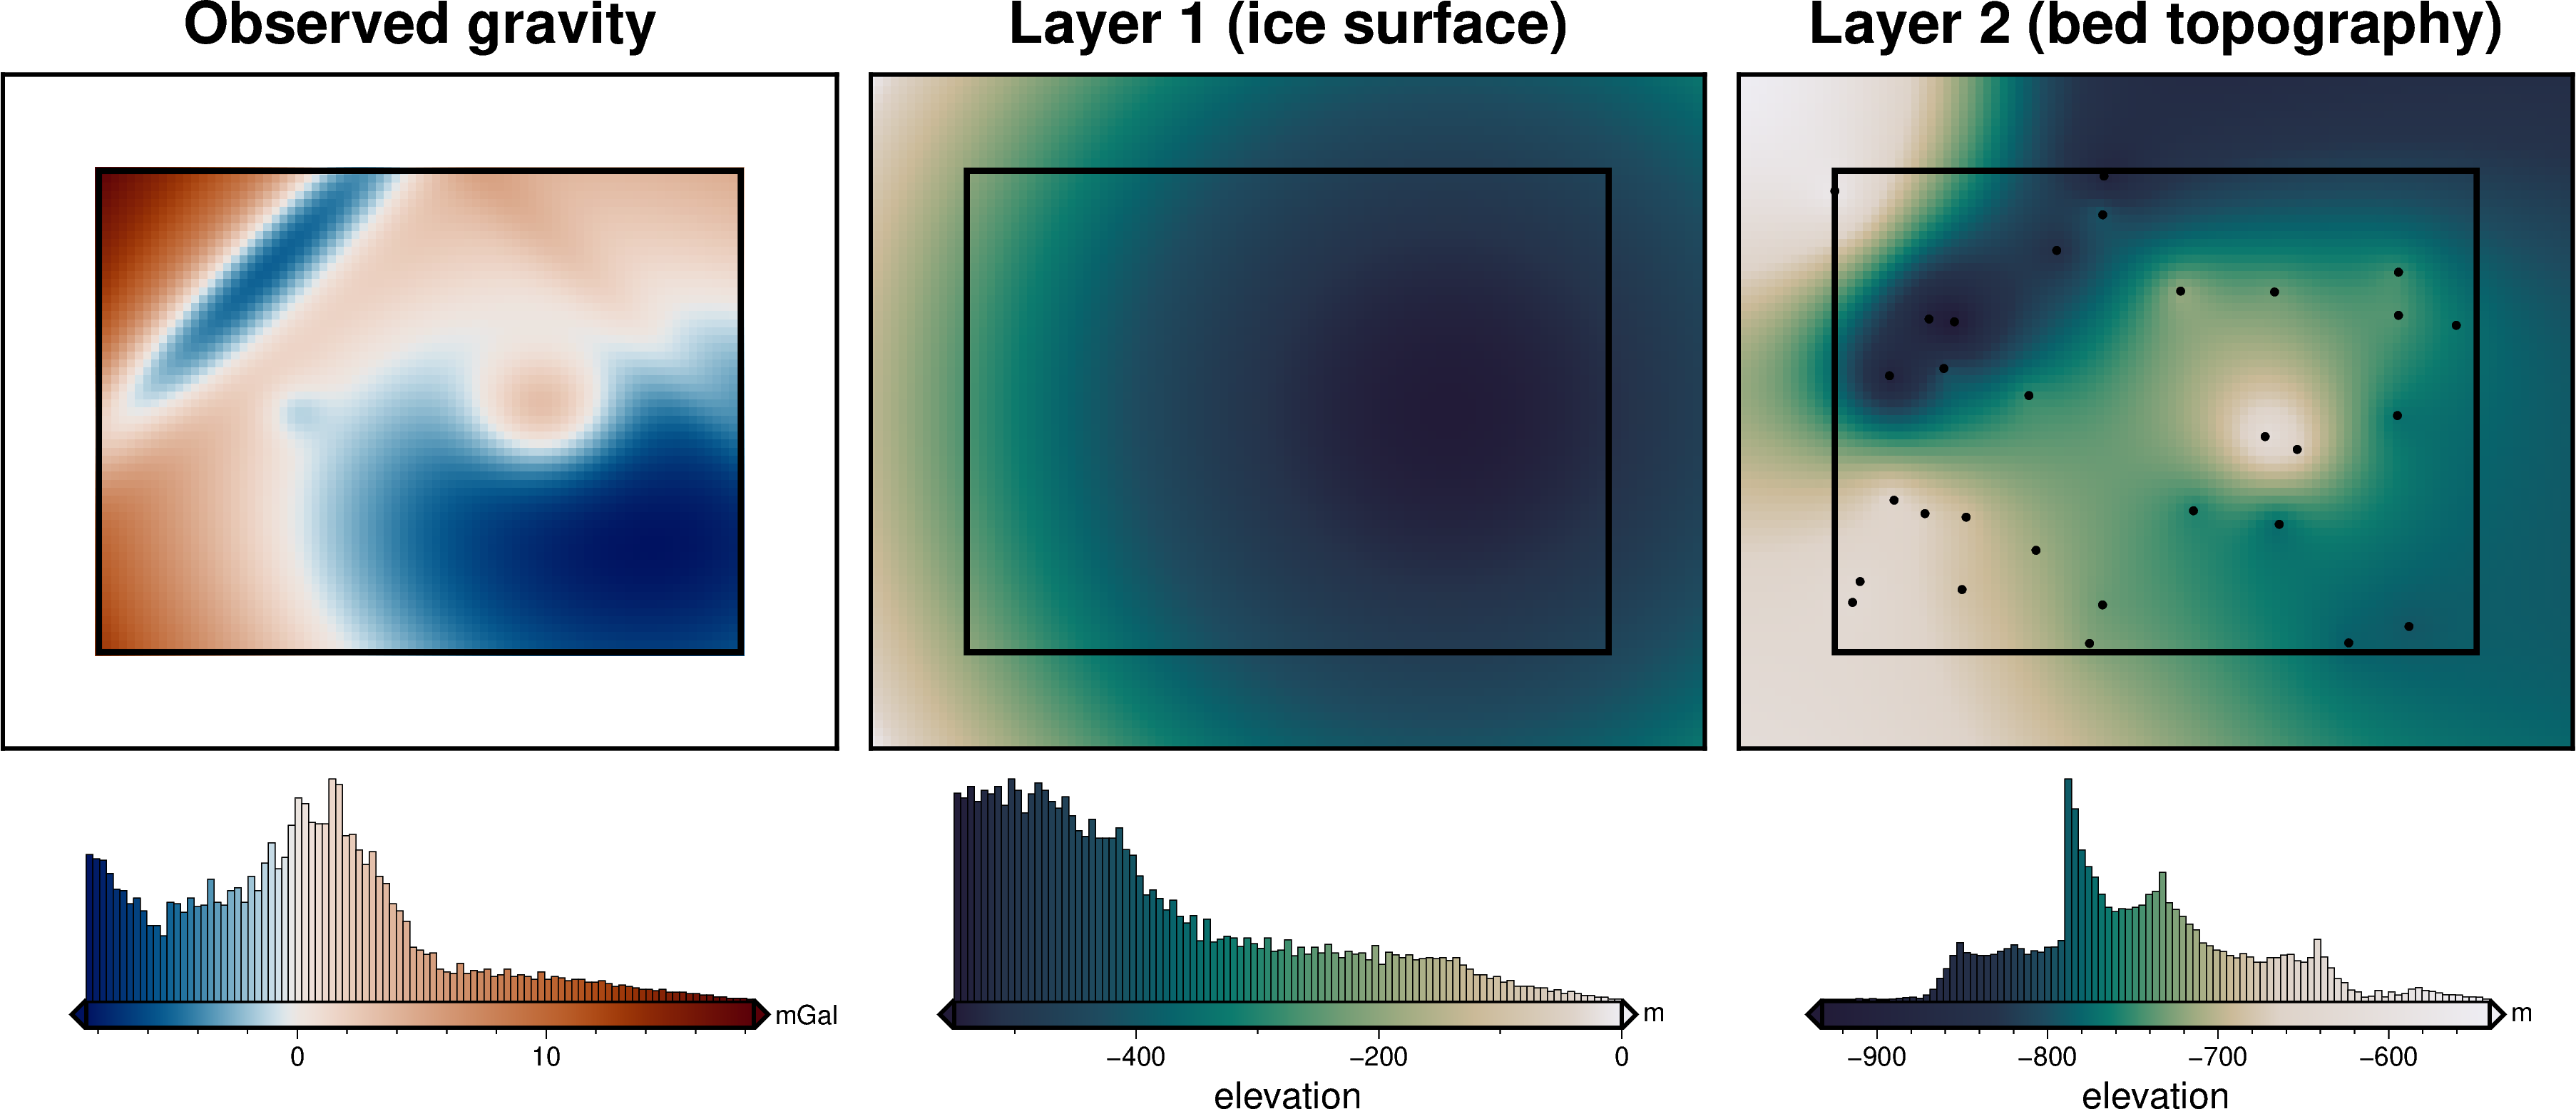

In [7]:
# plot observed gravity
fig = maps.plot_grd(
    grid=Gobs,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Observed gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)

# plot layer 1
fig = maps.plot_grd(
    grid=layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 1 (ice surface)",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 2 (bed topography)",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)

# plot constraint points
fig.plot(
    x=constraint_points.x,
    y=constraint_points.y,
    style="c.1c",
    color="black",
)

fig.show()

# Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast across Layer 1 (air-ice), Layer 2 (ice-bed), and Layer 3 (regional field). Since we want to invert for Layer 2, we need to remove the component of this gravity from Layer 1 and Layer 3. Here we show how to remove the Layer 1 component, and later will show how to remove the Layer 3 component.

To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of Layer 1. The prisms extend above or below this reference, towards Layer 1. Prisms above the reference are assigned a positive density contrast ($\rho_{ice}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{ice}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bed elevation doesn't intersect Layer 1. This means the Layer 1 density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

## Ice prisms

In [8]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    top=layer1,
    bottom=layer1.values.mean(),
    density=xr.where(layer1>=layer1.values.mean(), 917, -917),
)

plots.show_prism_layers(
    [layer1_prisms],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    zscale=100,
    clip_box=False,
    log_scale=False,
)

/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:41: PyVistaDeprecationWarning: `ipyvtklink` backend is deprecated and has been replaced by the `trame` backend.
  warnings.warn(


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## ice gravity

In [9]:
# calculate gravity of layer1
layer1_grid, layer1_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    grav,
    names=['layer1_prisms'],
    remove_mean=True,
    progressbar=True,
    plot=False,
)

grav['layer1_forward'] = layer1_df.forward_total

# subtract from observed gravity
grav['Gobs_corr']=grav.Gobs - grav.layer1_forward

# center on 0
grav['Gobs_corr'] -= grav['Gobs_corr'].mean()

# grid the results
layer1_forward = grav.set_index(["y", "x"]).to_xarray().layer1_forward
Gobs_corr = grav.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
layer1_forward -= layer1_forward.values.mean()
Gobs_corr -= Gobs_corr.values.mean()
grav

  0%|          | 0/4941 [00:02<?, ?it/s]

,x,y,Gobs,z,layer1_forward,Gobs_corr
0,0.0,0.0,13.529403,1000.0,9.079567,4.449836
1,1000.0,0.0,13.007873,1000.0,8.764314,4.243560
2,2000.0,0.0,12.486292,1000.0,8.450560,4.035731
3,3000.0,0.0,11.966150,1000.0,8.139163,3.826987
4,4000.0,0.0,11.448589,1000.0,7.830770,3.617819
...,...,...,...,...,...,...
4936,76000.0,60000.0,4.327390,1000.0,-0.331436,4.658825
4937,77000.0,60000.0,4.407698,1000.0,-0.239442,4.647140
4938,78000.0,60000.0,4.490917,1000.0,-0.142035,4.632952
4939,79000.0,60000.0,4.576358,1000.0,-0.039275,4.615633


returning grid with new region and/or registration, same spacing
returning grid with new region and/or registration, same spacing


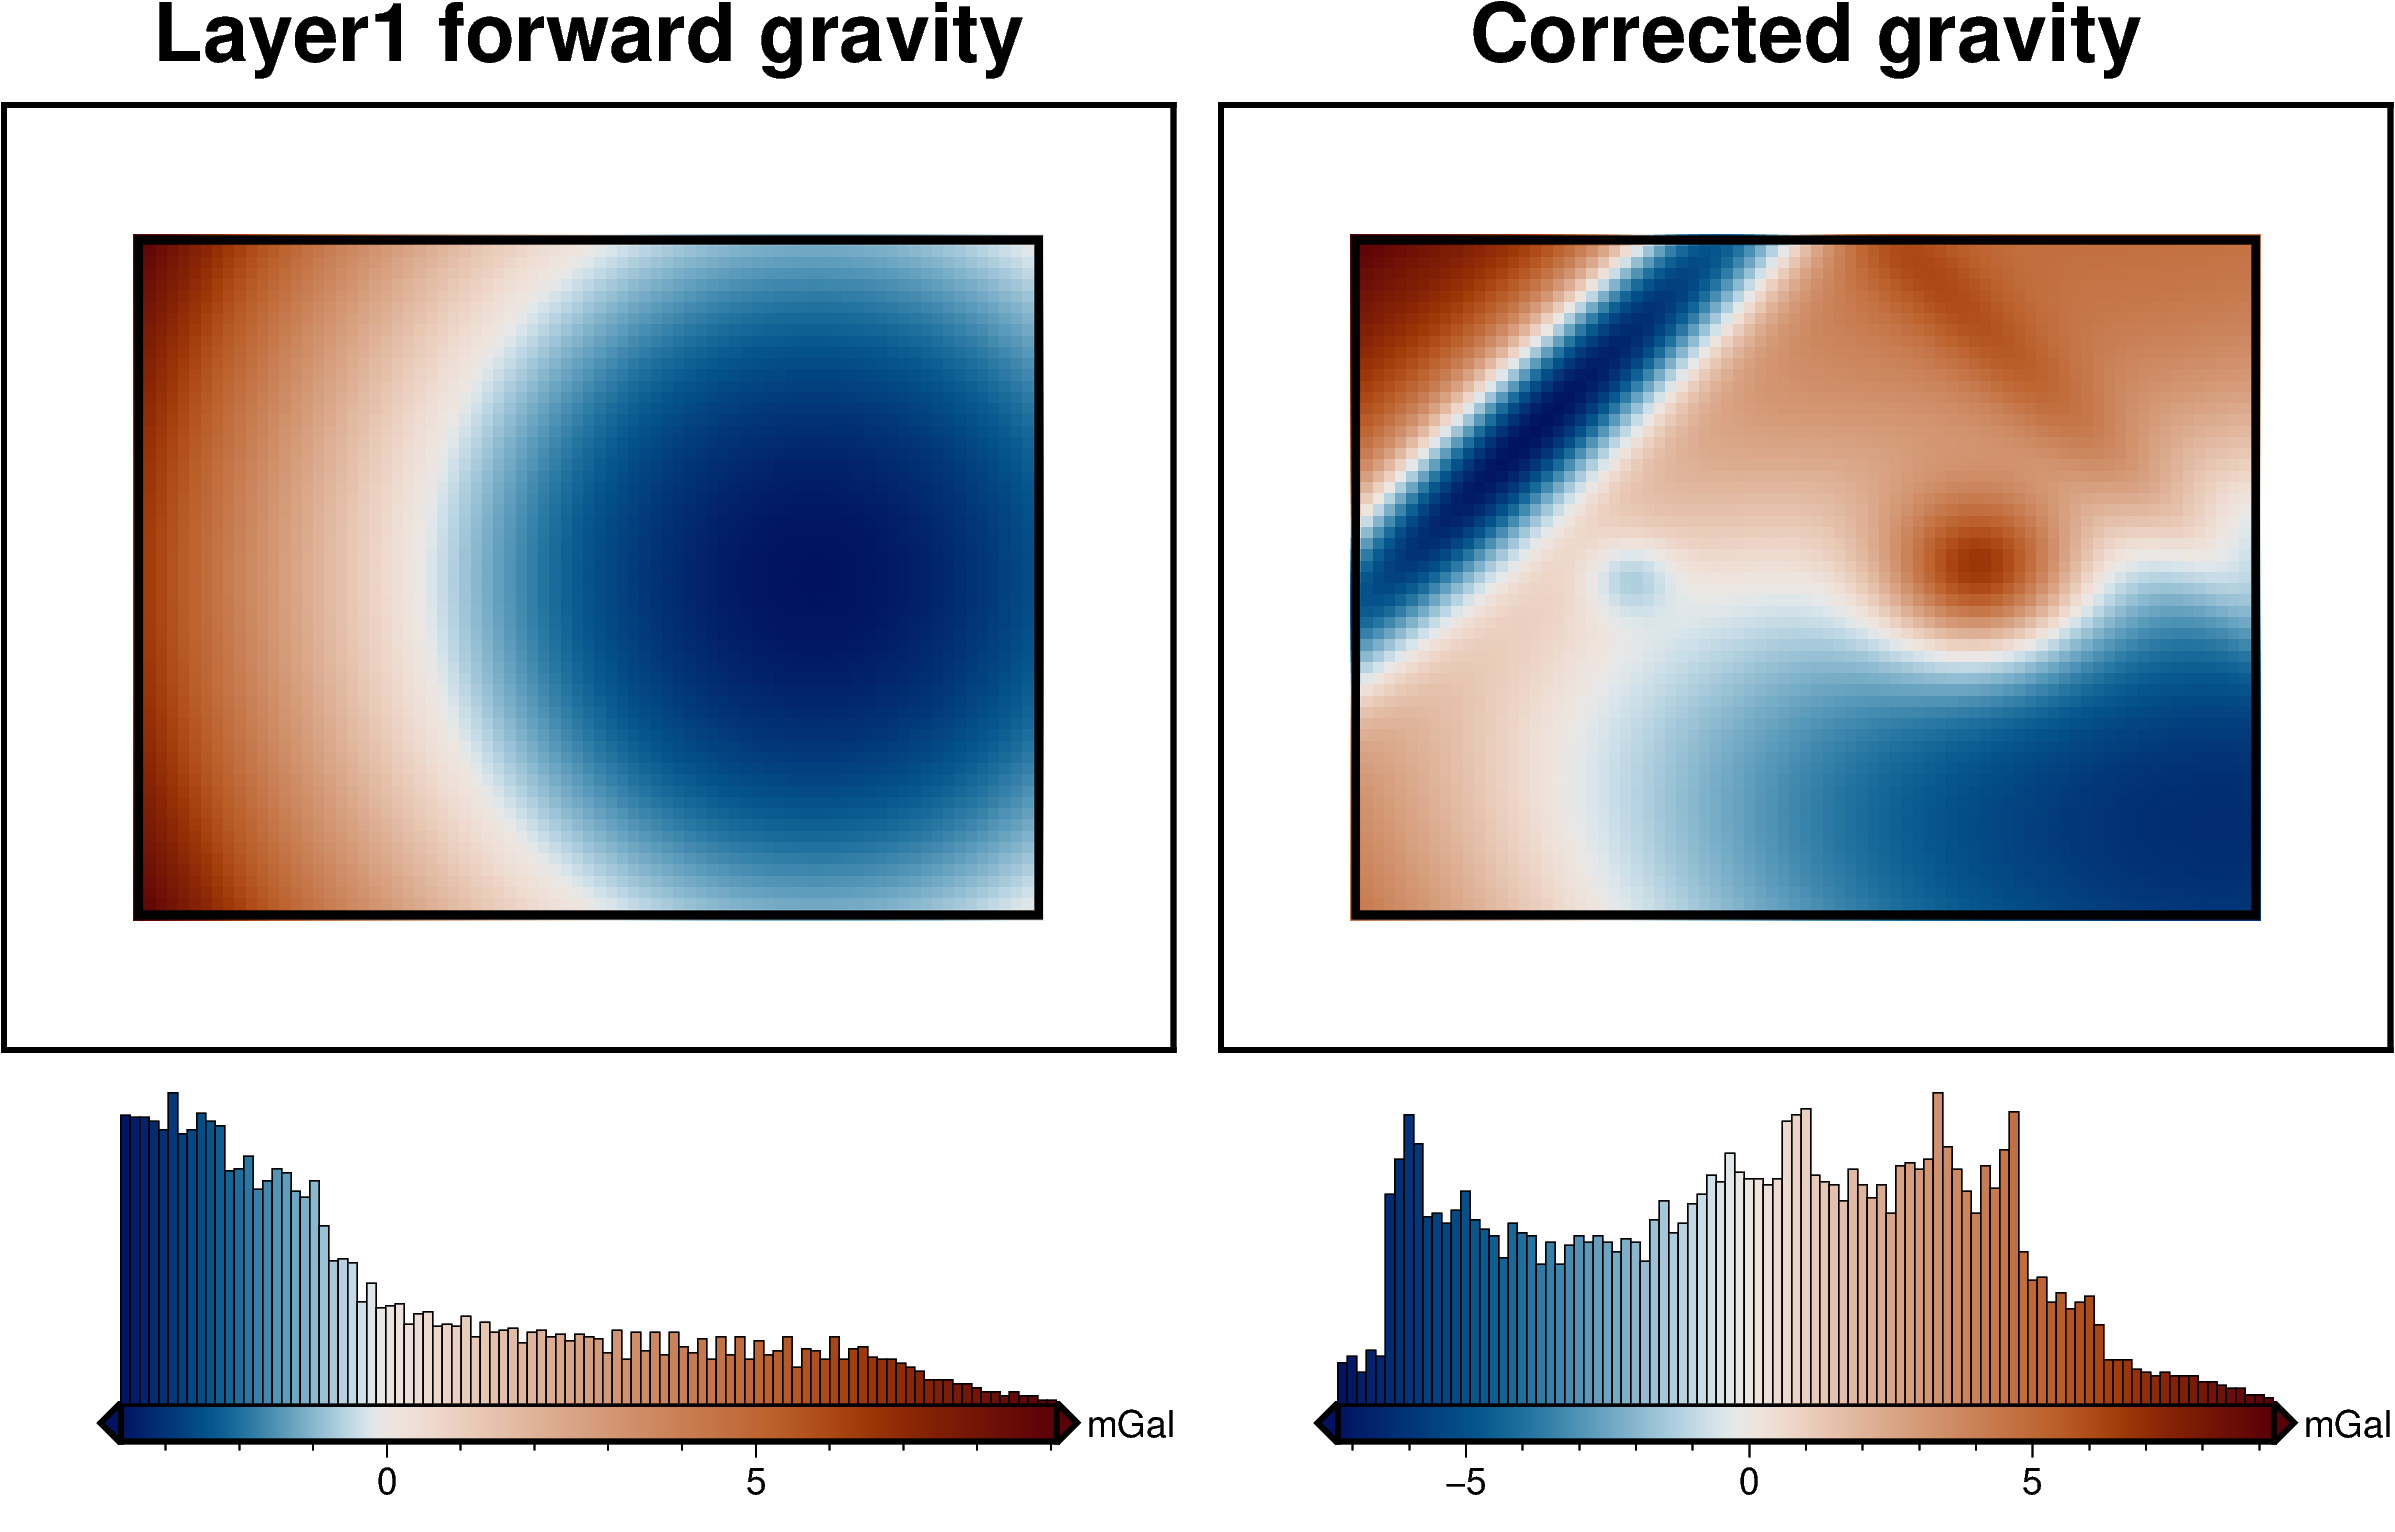

In [10]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title='Layer1 forward gravity',
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)

# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution Layer 2 density contrast. This will be the input into our inversion.


## Bed prisms

In [11]:
# create prisms around Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    top=starting_layer2,
    bottom=starting_layer2.values.mean(),
    density=xr.where(starting_layer2>=starting_layer2.values.mean(), 2300-917, -(2300-917)),
)

plots.show_prism_layers(
    [layer2_prisms],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    zscale=100,
    clip_box=False,
    log_scale=False,
)

/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:41: PyVistaDeprecationWarning: `ipyvtklink` backend is deprecated and has been replaced by the `trame` backend.
  warnings.warn(


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## bed gravity

In [12]:
# calculate gravity of layer1
layer2_forward, layer2_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    grav,
    names=['layer2_prisms'],
    remove_mean=True,
    progressbar=True,
    plot=False,
)
layer2_forward = layer2_forward.forward_total

grav['layer2_forward'] = layer2_df.forward_total
grav

  0%|          | 0/4941 [00:00<?, ?it/s]

,x,y,Gobs,z,layer1_forward,Gobs_corr,layer2_forward
0,0.0,0.0,13.529403,1000.0,9.079567,4.449836,5.728250
1,1000.0,0.0,13.007873,1000.0,8.764314,4.243560,5.699670
2,2000.0,0.0,12.486292,1000.0,8.450560,4.035731,5.656611
3,3000.0,0.0,11.966150,1000.0,8.139163,3.826987,5.598543
4,4000.0,0.0,11.448589,1000.0,7.830770,3.617819,5.525915
...,...,...,...,...,...,...,...
4936,76000.0,60000.0,4.327390,1000.0,-0.331436,4.658825,-3.435989
4937,77000.0,60000.0,4.407698,1000.0,-0.239442,4.647140,-3.460531
4938,78000.0,60000.0,4.490917,1000.0,-0.142035,4.632952,-3.485066
4939,79000.0,60000.0,4.576358,1000.0,-0.039275,4.615633,-3.508899


returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


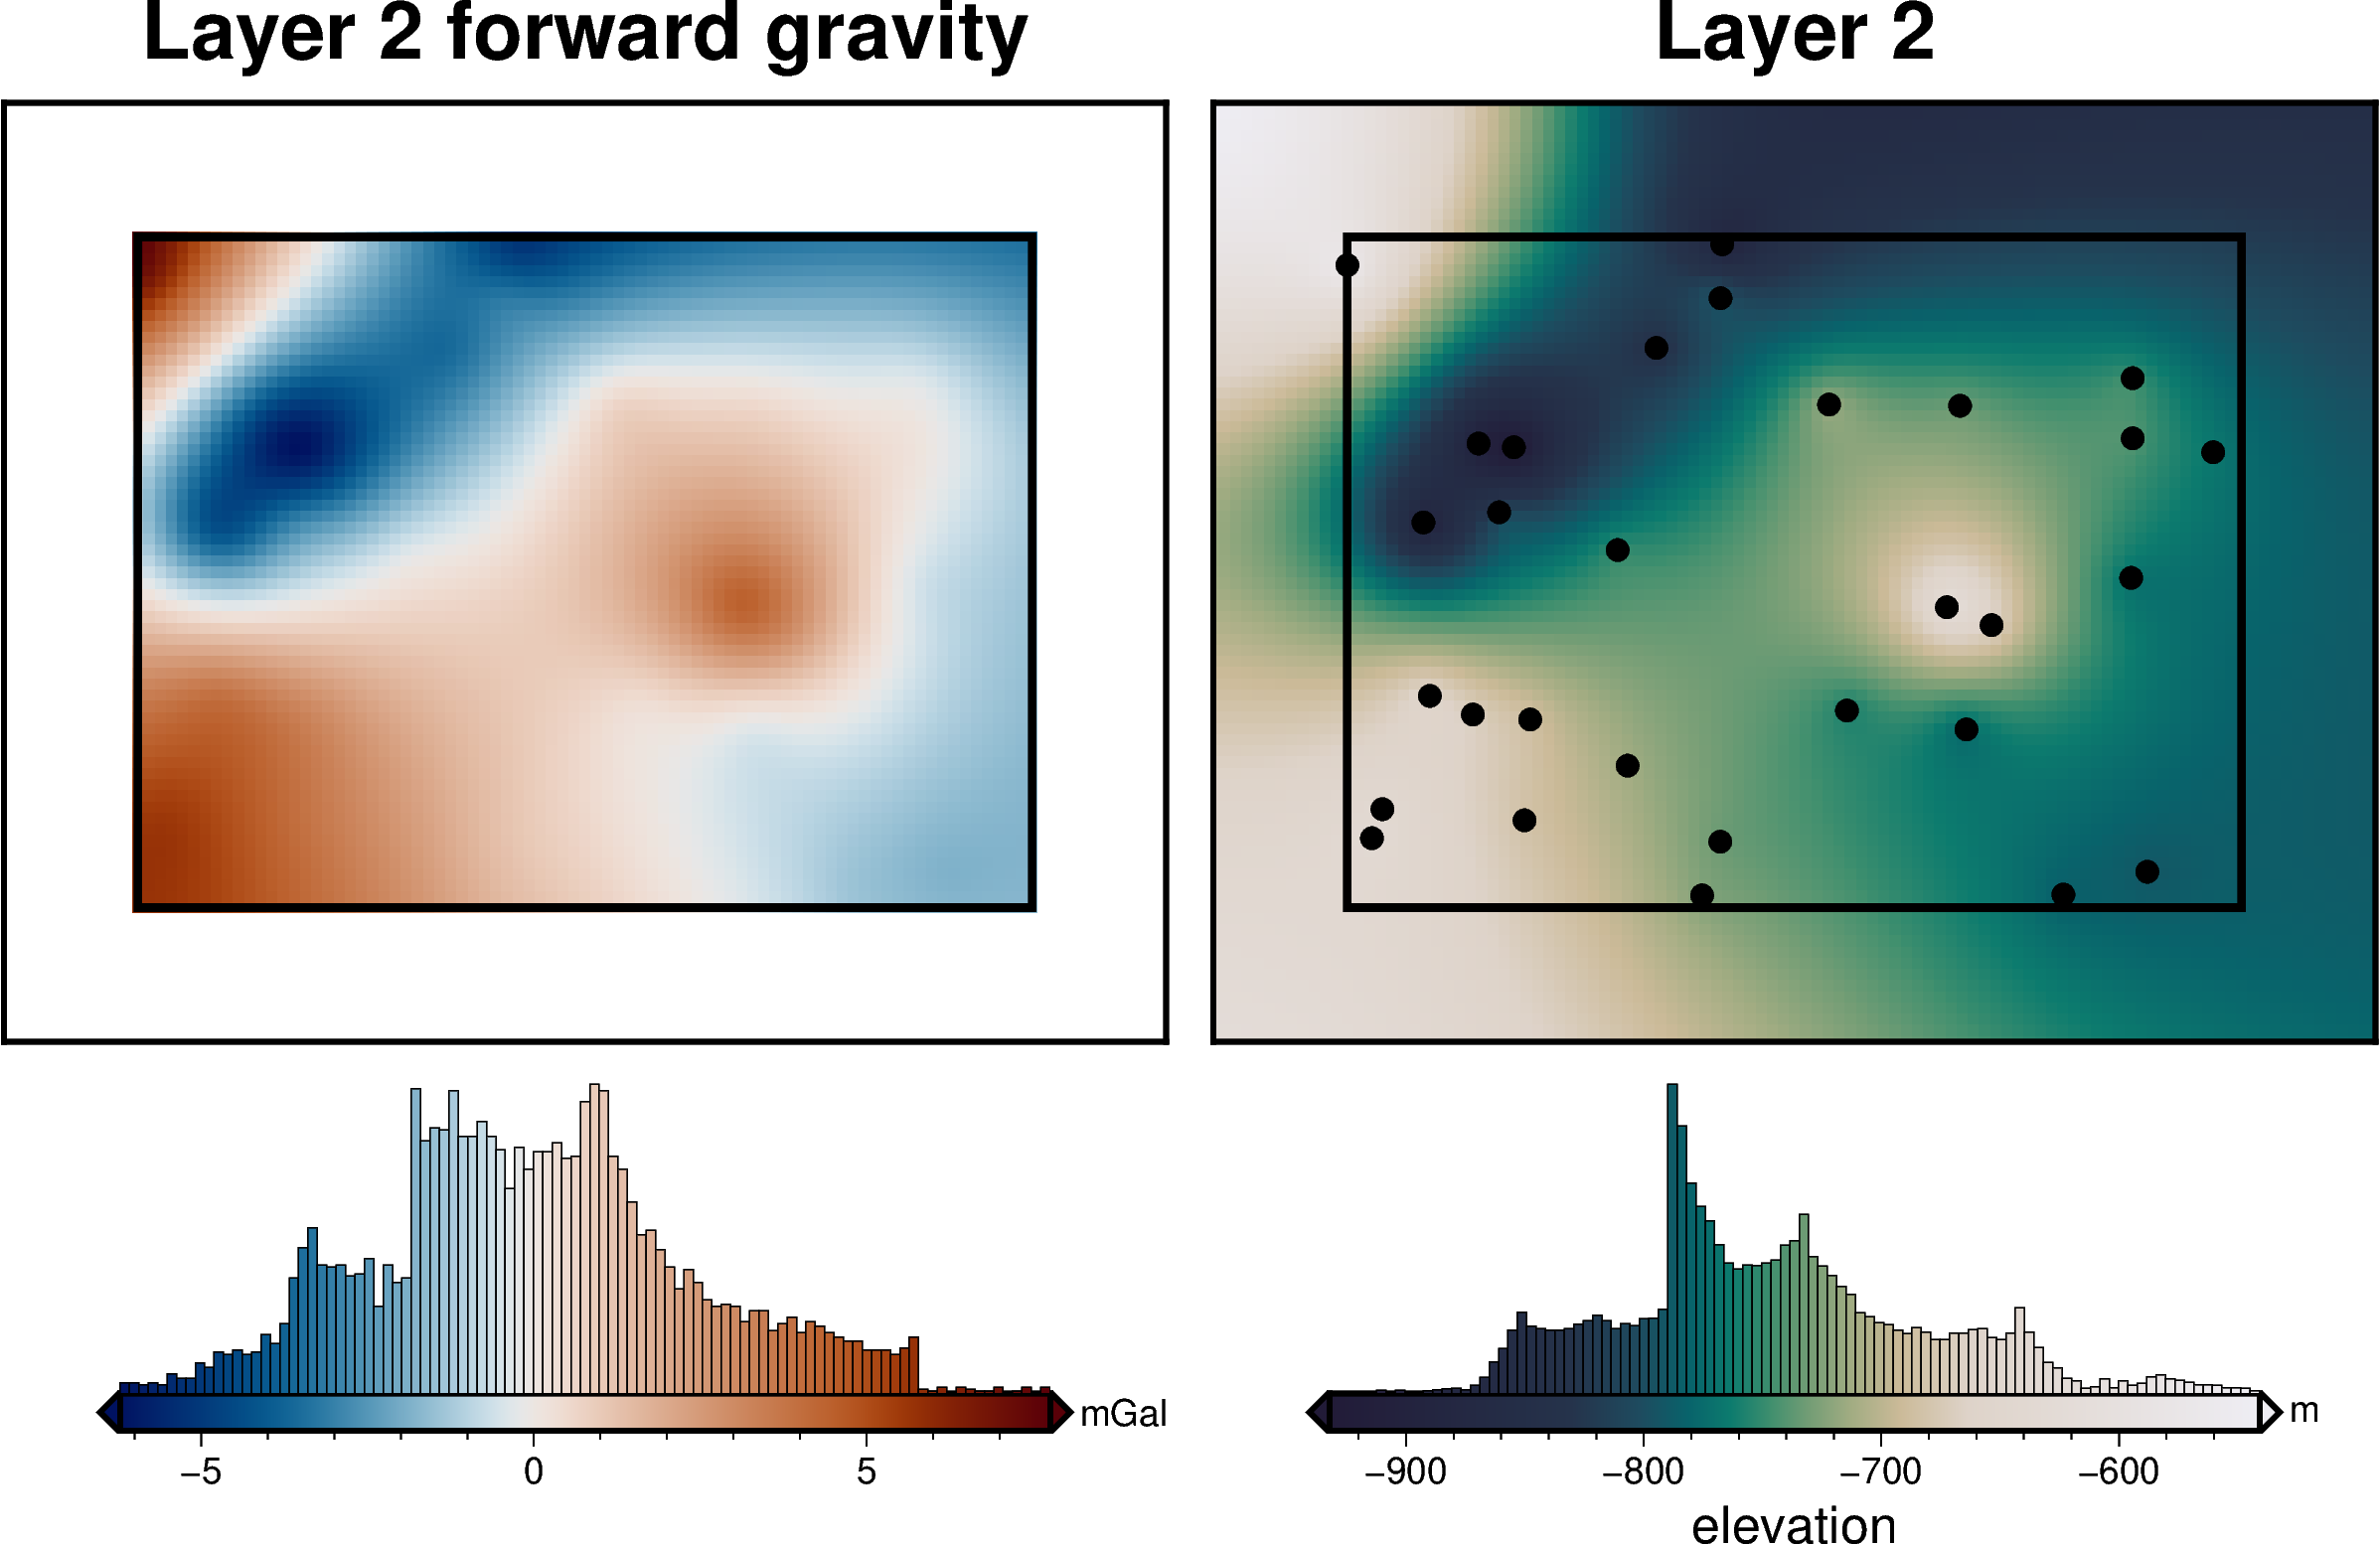

In [13]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=layer2_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Layer 2 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)

# plot layer 2 topography
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
)
fig.show()

## calculate misfit

returning original grid
returning original grid


,x,y,Gobs,z,layer1_forward,Gobs_corr,layer2_forward,misfit
0,0.0,0.0,13.529403,1000.0,9.079567,4.449836,5.728250,-1.278414
1,1000.0,0.0,13.007873,1000.0,8.764314,4.243560,5.699670,-1.456111
2,2000.0,0.0,12.486292,1000.0,8.450560,4.035731,5.656611,-1.620879
3,3000.0,0.0,11.966150,1000.0,8.139163,3.826987,5.598543,-1.771556
4,4000.0,0.0,11.448589,1000.0,7.830770,3.617819,5.525915,-1.908096
...,...,...,...,...,...,...,...,...
4936,76000.0,60000.0,4.327390,1000.0,-0.331436,4.658825,-3.435989,8.094814
4937,77000.0,60000.0,4.407698,1000.0,-0.239442,4.647140,-3.460531,8.107670
4938,78000.0,60000.0,4.490917,1000.0,-0.142035,4.632952,-3.485066,8.118018
4939,79000.0,60000.0,4.576358,1000.0,-0.039275,4.615633,-3.508899,8.124532


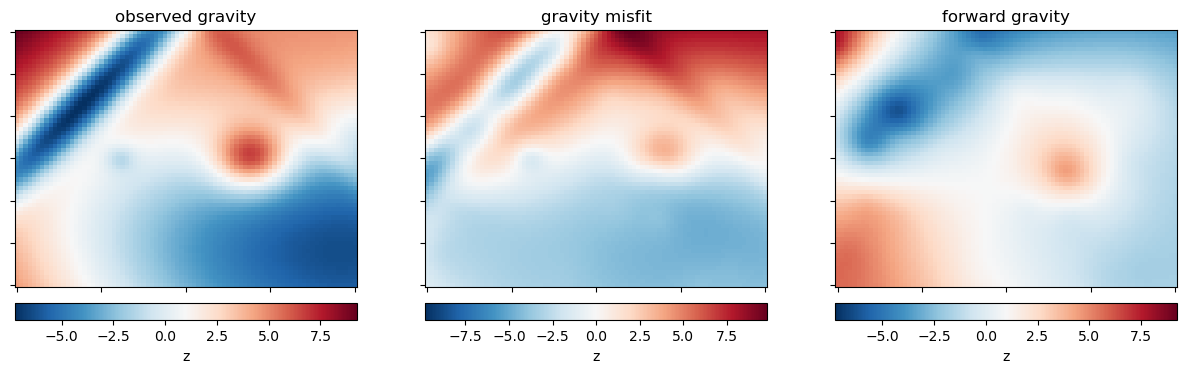

In [14]:
df_misfit = inv.misfit(
    input_grav = grav,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=grav_spacing,
    # plot=False,
    # plot_type='pygmt',
)
df_misfit

## Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `Layer 2` and `Layer 3`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `Layer 2` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of `Layer 2`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `Layer 2` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `Layer 2` and the low-resolution `Layer 2`. 

If we fail to accurately remove the `regional` signal, the resulting `Layer 2` surface after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we create the synthetic model, we precisely know the regional component (the forward gravity of `Layer 3`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

In [ ]:
# load the true regional gravity anomaly
true_layer3_grav = fetch.resample_grid(
    synthetic_gravity.Layer3,
    region=inversion_region,
    spacing=grav_spacing,
    registration=registration,
)

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) `Filter` method: Apply a low-pass filter to the misfit
2) `Trend` method: Fit a trend to the misfit
3) `Constraints` method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) `Equivalent-Sources` method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, these are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in your choice of:
a) a `regional misfit` closest to the true layer 3 forward gravity,
b) the smallest `residuals` at the constraint points

Since we know the true `regional` field, we will use method a). For a true inversion where you don't know the `regional` field, you can use method b). This method finds the seperation method which minimize the `residuals` at contraint points. Since at these contraint points you know the starting layer elevation is accurate, the misfit should be entirely due to the `regional` field, and the `residual` should be close to 0. 

Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [ ]:
kwargs = dict(
    method='regional comparison', # compare layer3 forward grav and calculated regional
    # method='minimize constraints', # minimize calculated residuals at constraints
    input_grav=grav,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_layer3_grav,
    constraints=constraint_points,
)

#### Optimize 4 methods together

In [ ]:
study, method = inv_utils.optimize_regional_together(
    n_trials=10, 
    **kwargs)

# plot best result
inv_utils.plot_best_param(study, **kwargs)

In [ ]:
study

#### Optimize methods individually

In [ ]:
studies = inv_utils.optimize_regional_loop(
    n_trials=5, 
    **kwargs)

# plot best results
inv_utils.plot_best_params_per_method(studies, **kwargs)

In [ ]:
for k, v in studies.items():
    v['params_method']=k

combined_studies = pd.concat(studies.values(), ignore_index=True).sort_values(by="value")
combined_studies.head()

#### Optimize single method

In [ ]:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

study = inv_utils.optimize_regional(
    n_trials=5,
    regional_method=regional_method,
    **kwargs)

# plot best results
inv_utils.plot_best_param(study, regional_method=regional_method, **kwargs)

## Best regional seperation

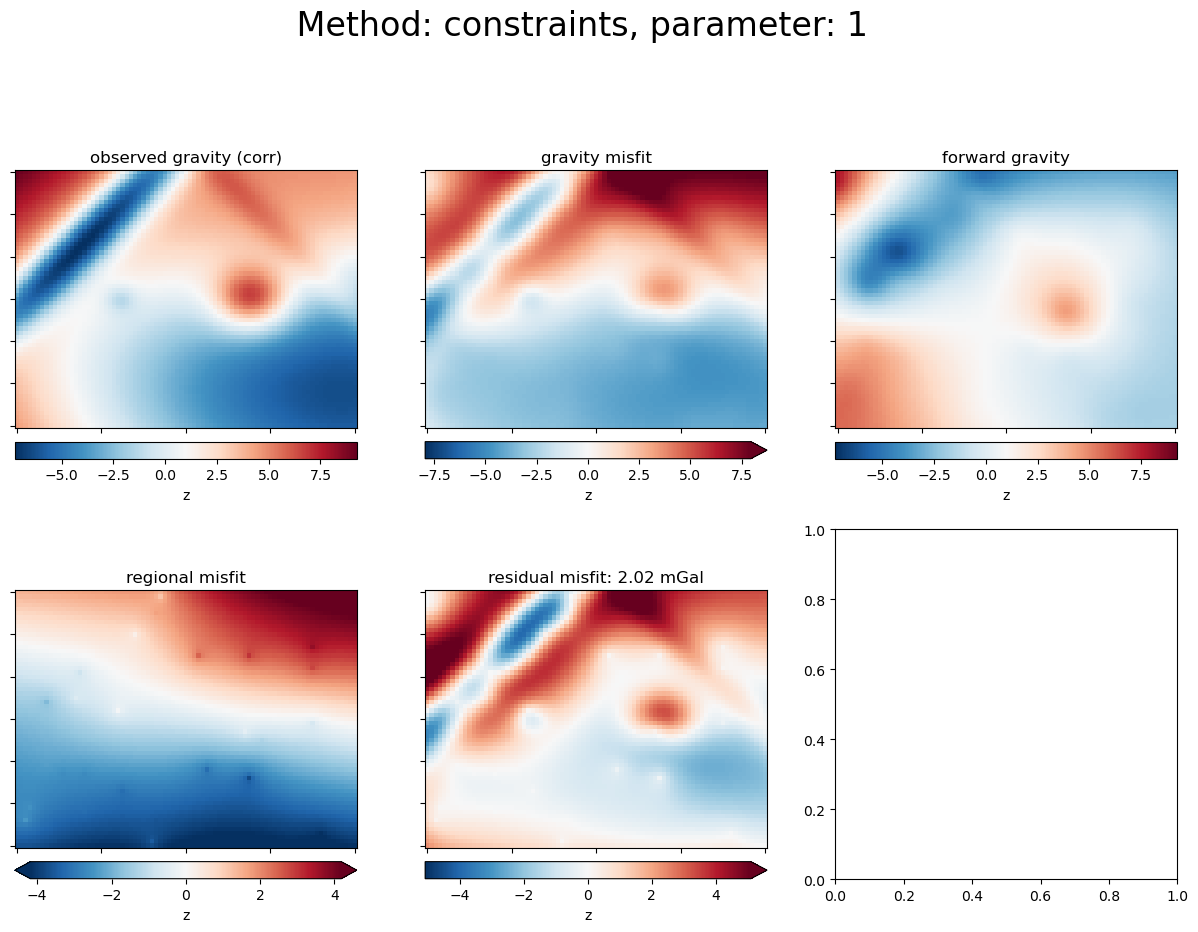

In [15]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
param = 1

df_anomalies = inv.regional_seperation(
        input_grav=grav,
        input_forward_column = 'layer2_forward',
        input_grav_column = 'Gobs_corr',
        grav_spacing=grav_spacing,
        regional_method=regional_method,
        inversion_region=inversion_region,
        # filter kwargs
        filter=f"g{param}",
        # trend kwargs
        trend=param,
        fill_method="pygmt",
        # fill_method='rioxarray',
        # constraint kwargs
        constraints=constraint_points,
        tension_factor=param,
        # eq sources kwargs
        eq_sources=param,
        depth_type="relative",
        eq_damping=None,
        block_size=grav_spacing,
    )

anom_grids = plots.anomalies_plotting(
        df_anomalies,
        region=inversion_region,
        grav_spacing=grav_spacing,
        title=f" Method: {regional_method}, parameter: {param}",
        # constraints=constraint_points,
        input_forward_column = 'layer2_forward',
        input_grav_column = 'Gobs_corr',
    )

In [16]:
df_anomalies

,x,y,Gobs,z,layer1_forward,Gobs_corr,layer2_forward,misfit,reg,res
0,0.0,0.0,13.529403,1000.0,9.079567,4.449836,5.728250,-1.278414,-3.650166,2.371753
1,1000.0,0.0,13.007873,1000.0,8.764314,4.243560,5.699670,-1.456111,-3.635635,2.179524
2,2000.0,0.0,12.486292,1000.0,8.450560,4.035731,5.656611,-1.620879,-3.636131,2.015252
3,3000.0,0.0,11.966150,1000.0,8.139163,3.826987,5.598543,-1.771556,-3.650542,1.878986
4,4000.0,0.0,11.448589,1000.0,7.830770,3.617819,5.525915,-1.908096,-3.676313,1.768217
...,...,...,...,...,...,...,...,...,...,...
4936,76000.0,60000.0,4.327390,1000.0,-0.331436,4.658825,-3.435989,8.094814,4.744907,3.349907
4937,77000.0,60000.0,4.407698,1000.0,-0.239442,4.647140,-3.460531,8.107670,4.767791,3.339879
4938,78000.0,60000.0,4.490917,1000.0,-0.142035,4.632952,-3.485066,8.118018,4.790323,3.327695
4939,79000.0,60000.0,4.576358,1000.0,-0.039275,4.615633,-3.508899,8.124532,4.812646,3.311885


In [17]:
anom_grids.keys()

dict_keys(['Gobs_corr', 'misfit', 'layer2_forward', 'reg', 'res'])

Sample anomaly grids at contraint points

In [18]:
constraint_points = profile.sample_grids(
    constraint_points, 
    anom_grids["Gobs_corr"], 
    "grav_corrected",
    )

constraint_points = profile.sample_grids(
    constraint_points, 
    anom_grids["layer2_forward"], 
    "forward_total",
    )

constraint_points = profile.sample_grids(
    constraint_points, 
    anom_grids["misfit"], 
    "misfit",
    )

constraint_points = profile.sample_grids(
    constraint_points, 
    anom_grids["reg"], 
    "reg",
    )

constraint_points = profile.sample_grids(
    constraint_points, 
    anom_grids["res"], 
    "res",
    )

constraint_points

,x,y,grav_corrected,forward_total,misfit,reg,res
0,33361.760376,5900.810030,-2.424827,1.199776,-3.624603,-3.601214,-0.023389
1,57625.959475,25266.457500,2.056325,3.366374,-1.310050,-1.203415,-0.106635
2,9.149985,57473.371809,8.789580,7.561272,1.228309,1.189896,0.038413
3,24186.605811,31989.917098,-0.403050,-0.385638,-0.017411,-0.101546,0.084135
4,11740.471265,41512.626837,-6.200682,-5.710101,-0.490581,-0.505204,0.014624
5,7387.087582,18930.937860,1.620764,3.918853,-2.298089,-2.321136,0.023047
6,14900.816910,41190.055661,-7.149330,-6.208391,-0.940940,-0.838349,-0.102590
7,27644.858163,50077.540314,-3.528872,-3.597673,0.068802,0.298183,-0.229381
8,31741.397938,1097.296641,-1.789798,1.620275,-3.410072,-3.519283,0.109210
9,43105.338720,45008.658897,3.188391,0.669172,2.519219,2.463325,0.055894


# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

In [19]:
prism_results, grav_results = inv.geo_inversion_dens_contrast(
    input_grav=df_anomalies,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    layer=starting_layer2,
    density_contrast=(2300-917),
    max_iterations=10,
    # optional
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.02,
    # upper_confining_layer=layer1,
    # deriv_type = "annulus", 
    deriv_type = "prisms", # default
    # jacobian_prism_size = 1,
    solver_type = "verde least squares", # default
    # solver_type = "scipy conjugate",
    # solver_type = "numpy least squares",
    # solver_type = "scipy least squares",
    # solver_type = "steepest descent",
    # solver_type = "gauss newton",
    # solver_damping = 1000,
    max_layer_change_per_iter = 50,

    # kwargs
    # registration="g",
)


##############################################################################################
iteration 1


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 168 m, RMSE:930 m
Layer correction (after clipped) mean: 6m, RMSE:38 m

updated misfit RMSE: 1.28
updated L2-norm: 1.13,  tolerance: 0.5
updated delta L2-norm : 1.26,  tolerance: 1.02

##############################################################################################
iteration 2


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 171 m, RMSE:656 m
Layer correction (after clipped) mean: 8m, RMSE:30 m

updated misfit RMSE: 0.98
updated L2-norm: 0.99,  tolerance: 0.5
updated delta L2-norm : 1.14,  tolerance: 1.02

##############################################################################################
iteration 3


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 164 m, RMSE:523 m
Layer correction (after clipped) mean: 13m, RMSE:28 m

updated misfit RMSE: 0.87
updated L2-norm: 0.93,  tolerance: 0.5
updated delta L2-norm : 1.06,  tolerance: 1.02

##############################################################################################
iteration 4


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 165 m, RMSE:482 m
Layer correction (after clipped) mean: 17m, RMSE:28 m

updated misfit RMSE: 0.82
updated L2-norm: 0.91,  tolerance: 0.5
updated delta L2-norm : 1.03,  tolerance: 1.02

##############################################################################################
iteration 5


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 170 m, RMSE:477 m
Layer correction (after clipped) mean: 17m, RMSE:28 m

updated misfit RMSE: 0.79
updated L2-norm: 0.89,  tolerance: 0.5
updated delta L2-norm : 1.02,  tolerance: 1.02

Inversion terminated after 5 iterations because there was no significant variation in the L2-norm


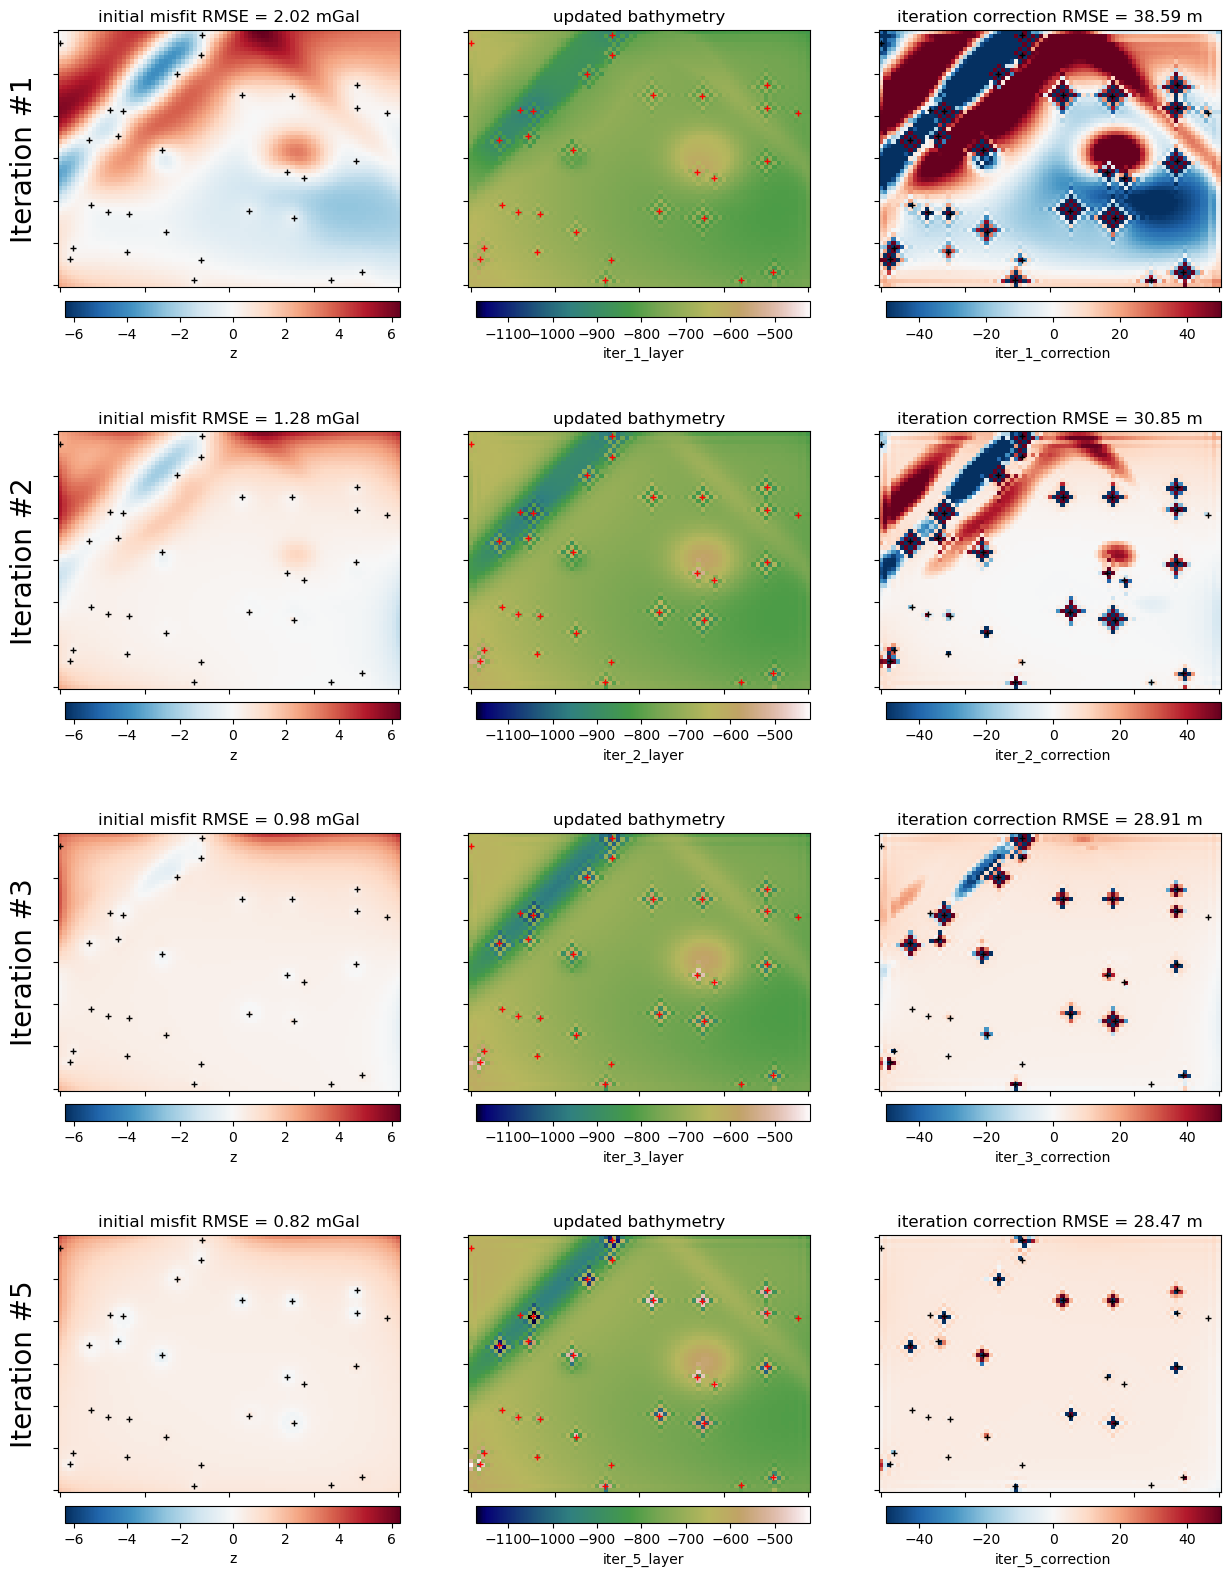

In [20]:
grids = plots.plot_inversion_results(
    grav_results,
    prism_results, 
    grav_region=inversion_region,
    grav_spacing=grav_spacing,
    constraints=constraint_points,
    plot_topo_results=False,
    plot_grav_results=False,
    iters_to_plot=4,
    )

# Compare
## compare inverted Layer2 to true Layer2

In [21]:
ds = prism_results.rename(columns={'easting':'x', 'northing':'y'}).set_index(['y', 'x']).to_xarray()

ds_inner = ds.sel(
    x=slice(inversion_region[0], inversion_region[1]),
    y=slice(inversion_region[2], inversion_region[3])
)

cols = [s for s in prism_results.columns.to_list() if "_layer" in s]
for i, j in enumerate(cols, start=1):
    dif = true_layer2 - ds_inner[j]
    RMSE = inv.RMSE(dif)
    print(f"RMSE iter {i}: {round(RMSE, 2)}m")

final_layer2 = ds_inner[cols[-1]]

RMSE iter 1: 38.0m
RMSE iter 2: 35.16m
RMSE iter 3: 37.5m
RMSE iter 4: 39.95m
RMSE iter 5: 42.43m


returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


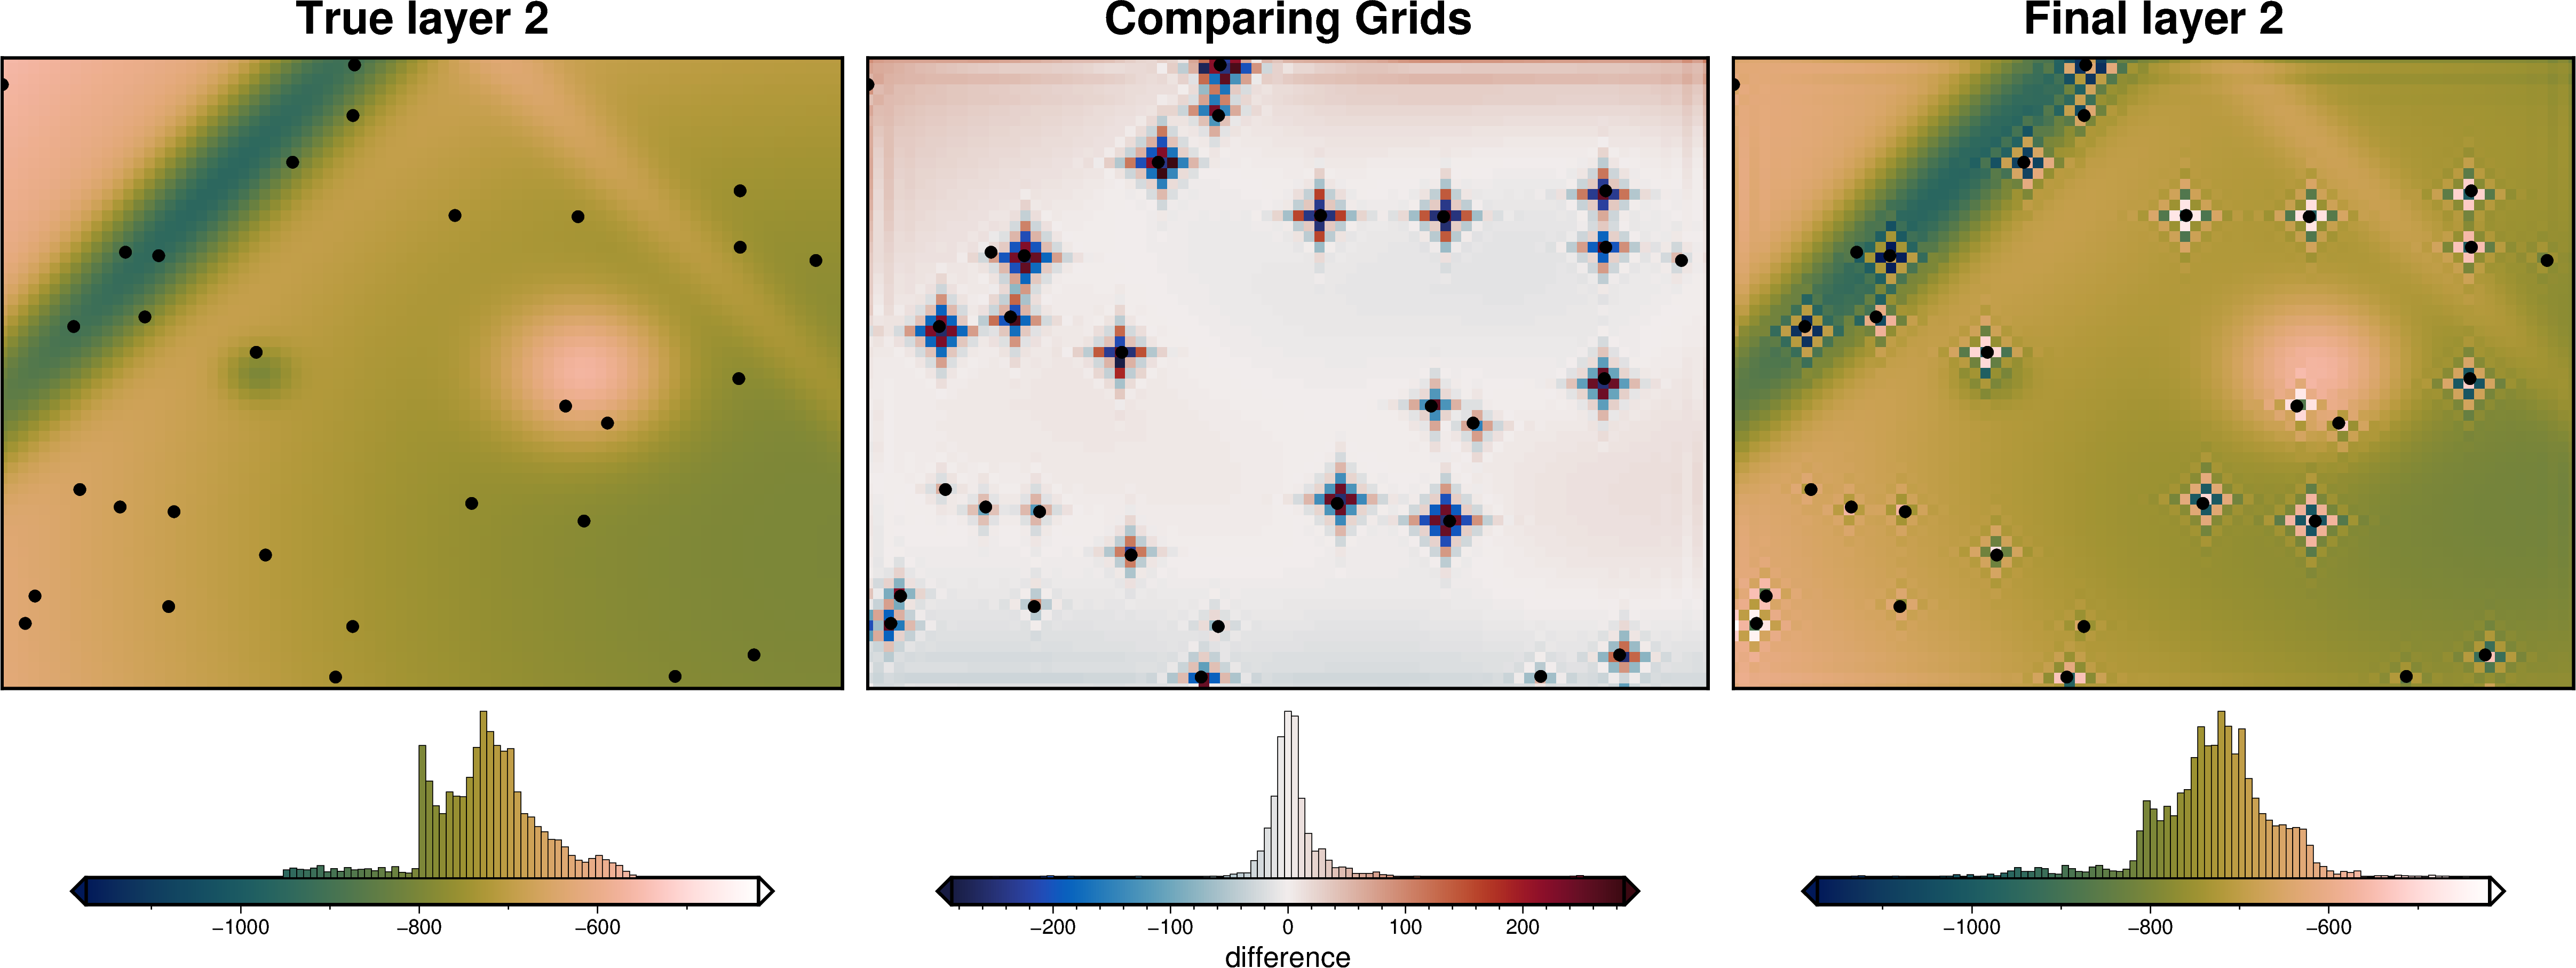

In [22]:
grids = utils.grd_compare(
    true_layer2,
    final_layer2,
    grid1_name='True layer 2',
    grid2_name='Final layer 2',
    region=inversion_region,
    plot=True,
    plot_type="pygmt",
    cmap='batlowW',
    # cmap="gist_earth",
    robust=True,
    points=constraint_points,
    hist=True,
    inset=False,
)

## compare inverted Layer2 to starting low-res Layer2

returning original grid
returning original grid


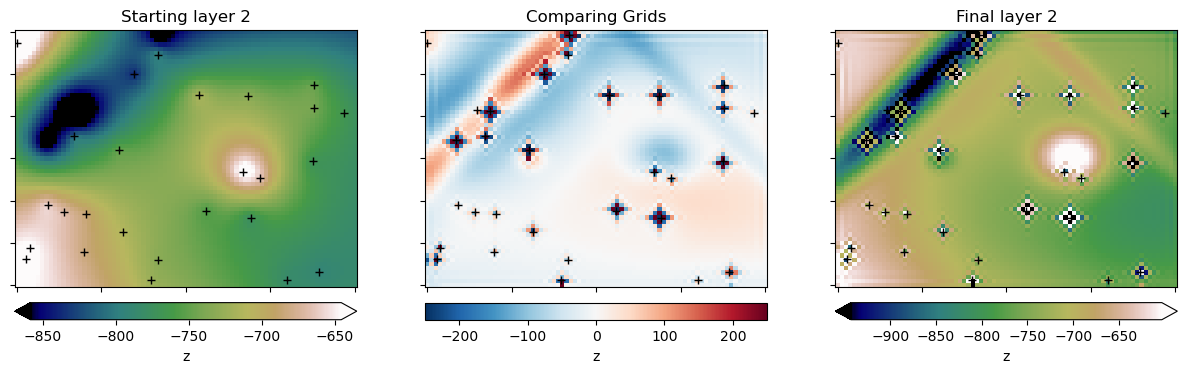

In [23]:
grids = utils.grd_compare(
    starting_layer2,
    final_layer2,
    grid1_name='Starting layer 2',
    grid2_name='Final layer 2',
    region=inversion_region,
    plot=True,
    plot_type="xarray",
    cmap="gist_earth",
    robust=True,
    points=constraint_points,
)

# Repeate with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [24]:
df_anomalies['res'] = synth.contaminate(
    df_anomalies.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies

,x,y,Gobs,z,layer1_forward,Gobs_corr,layer2_forward,misfit,reg,res
0,0.0,0.0,13.529403,1000.0,9.079567,4.449836,5.728250,-1.278414,-3.650166,2.596915
1,1000.0,0.0,13.007873,1000.0,8.764314,4.243560,5.699670,-1.456111,-3.635635,2.232333
2,2000.0,0.0,12.486292,1000.0,8.450560,4.035731,5.656611,-1.620879,-3.636131,2.141175
3,3000.0,0.0,11.966150,1000.0,8.139163,3.826987,5.598543,-1.771556,-3.650542,2.164407
4,4000.0,0.0,11.448589,1000.0,7.830770,3.617819,5.525915,-1.908096,-3.676313,2.006459
...,...,...,...,...,...,...,...,...,...,...
4936,76000.0,60000.0,4.327390,1000.0,-0.331436,4.658825,-3.435989,8.094814,4.744907,3.307959
4937,77000.0,60000.0,4.407698,1000.0,-0.239442,4.647140,-3.460531,8.107670,4.767791,3.257358
4938,78000.0,60000.0,4.490917,1000.0,-0.142035,4.632952,-3.485066,8.118018,4.790323,3.209056
4939,79000.0,60000.0,4.576358,1000.0,-0.039275,4.615633,-3.508899,8.124532,4.812646,3.389688


In [25]:
prism_results, grav_results = inv.geo_inversion_dens_contrast(
    input_grav=df_anomalies,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    layer=starting_layer2,
    density_contrast=(2300-917),
    max_iterations=10,
    # optional
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.02,
    # upper_confining_layer=layer1,
    # deriv_type = "annulus", 
    deriv_type = "prisms", # default
    # jacobian_prism_size = 1,
    solver_type = "verde least squares", # default
    # solver_type = "scipy conjugate",
    # solver_type = "numpy least squares",
    # solver_type = "scipy least squares",
    # solver_type = "steepest descent",
    # solver_type = "gauss newton",
    # solver_damping = 1000,
    max_layer_change_per_iter = 50,

    # kwargs
    # registration="g",
)


##############################################################################################
iteration 1


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 178 m, RMSE:1091 m
Layer correction (after clipped) mean: 4m, RMSE:48 m

updated misfit RMSE: 2.0
updated L2-norm: 1.41,  tolerance: 0.5
updated delta L2-norm : 1.01,  tolerance: 1.02

##############################################################################################
iteration 2


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 241 m, RMSE:1073 m
Layer correction (after clipped) mean: 5m, RMSE:43 m

updated misfit RMSE: 1.49
updated L2-norm: 1.22,  tolerance: 0.5
updated delta L2-norm : 1.16,  tolerance: 1.02

##############################################################################################
iteration 3


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 192 m, RMSE:825 m
Layer correction (after clipped) mean: 7m, RMSE:33 m

updated misfit RMSE: 1.12
updated L2-norm: 1.06,  tolerance: 0.5
updated delta L2-norm : 1.16,  tolerance: 1.02

##############################################################################################
iteration 4


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 174 m, RMSE:630 m
Layer correction (after clipped) mean: 9m, RMSE:29 m

updated misfit RMSE: 0.94
updated L2-norm: 0.97,  tolerance: 0.5
updated delta L2-norm : 1.09,  tolerance: 1.02

##############################################################################################
iteration 5


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 171 m, RMSE:537 m
Layer correction (after clipped) mean: 16m, RMSE:28 m

updated misfit RMSE: 0.86
updated L2-norm: 0.93,  tolerance: 0.5
updated delta L2-norm : 1.04,  tolerance: 1.02

##############################################################################################
iteration 6


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 174 m, RMSE:513 m
Layer correction (after clipped) mean: 17m, RMSE:28 m

updated misfit RMSE: 0.82
updated L2-norm: 0.91,  tolerance: 0.5
updated delta L2-norm : 1.03,  tolerance: 1.02

##############################################################################################
iteration 7


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 180 m, RMSE:511 m
Layer correction (after clipped) mean: 18m, RMSE:28 m

updated misfit RMSE: 0.79
updated L2-norm: 0.89,  tolerance: 0.5
updated delta L2-norm : 1.02,  tolerance: 1.02

Inversion terminated after 7 iterations because there was no significant variation in the L2-norm


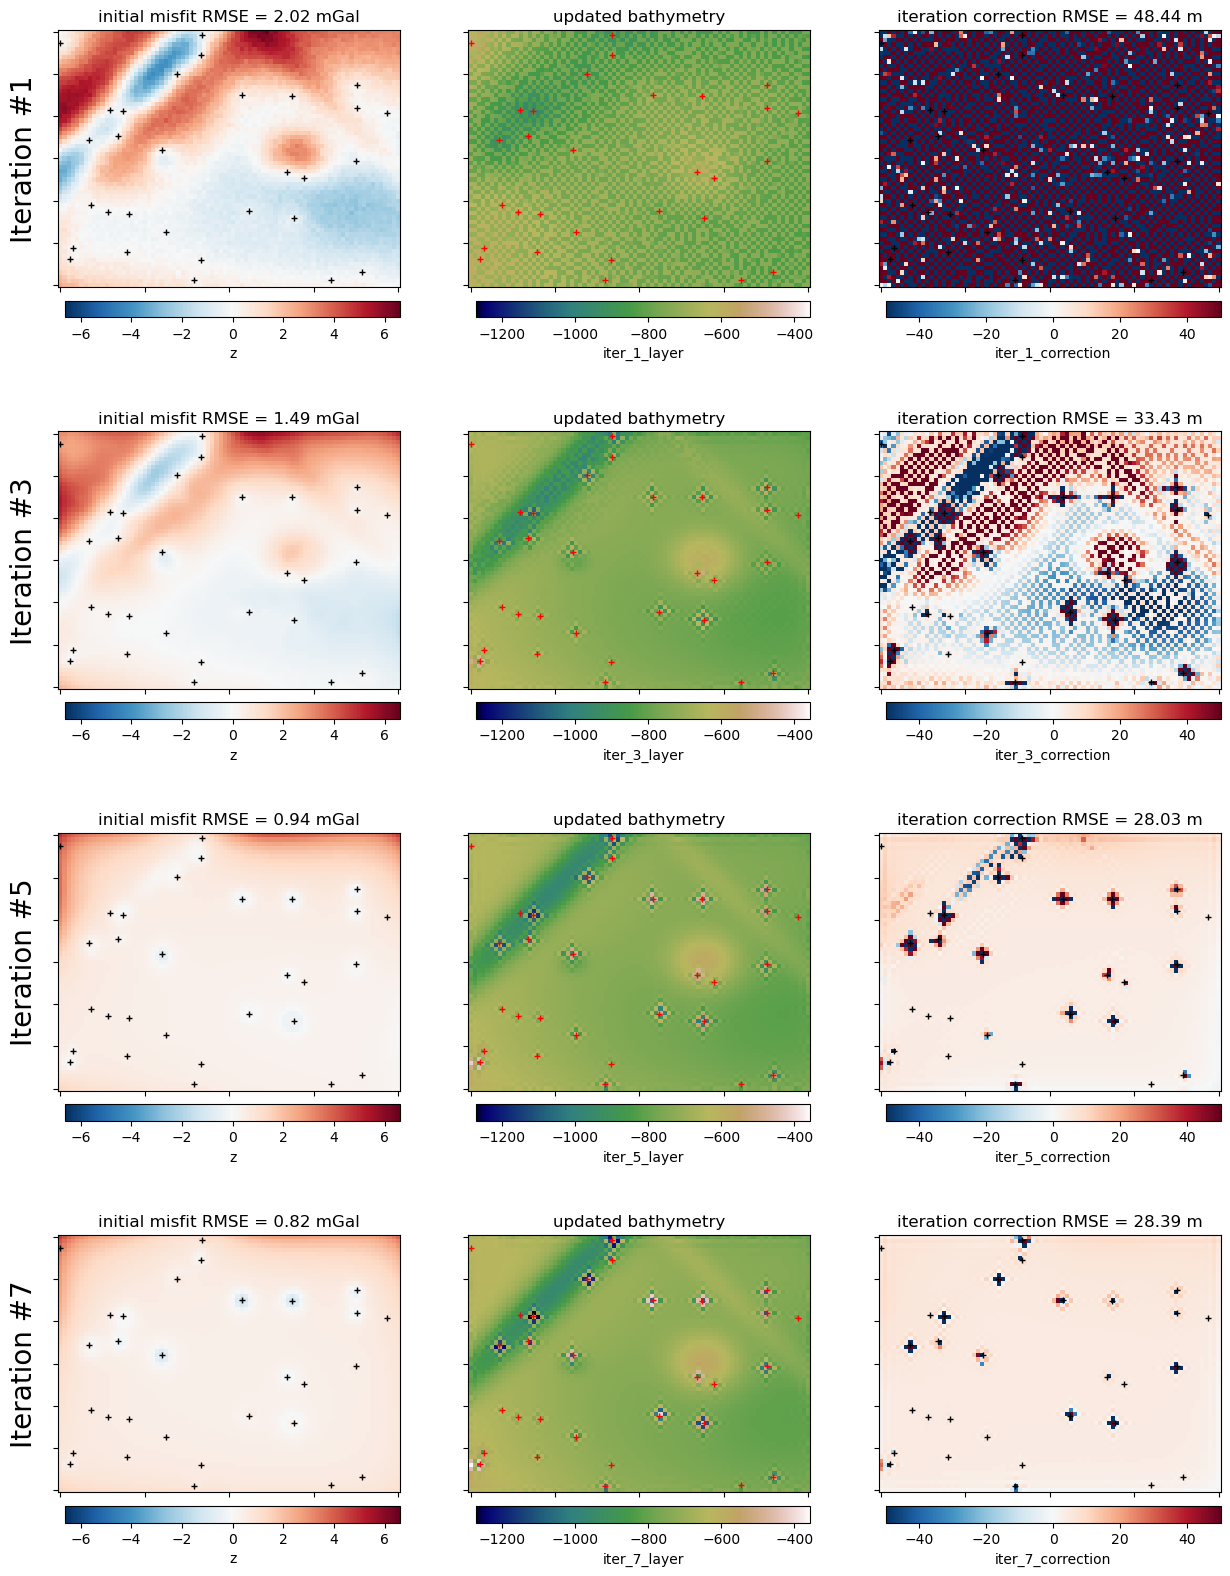

In [26]:
grids = plots.plot_inversion_results(
    grav_results,
    prism_results, 
    grav_region=inversion_region,
    grav_spacing=grav_spacing,
    constraints=constraint_points,
    plot_topo_results=False,
    plot_grav_results=False,
    iters_to_plot=4,
    )

In [27]:
ds_noise = prism_results.rename(columns={'easting':'x', 'northing':'y'}).set_index(['y', 'x']).to_xarray()

ds_noise_inner = ds_noise.sel(
    x=slice(inversion_region[0], inversion_region[1]),
    y=slice(inversion_region[2], inversion_region[3])
)

cols = [s for s in prism_results.columns.to_list() if "_layer" in s]
for i, j in enumerate(cols, start=1):
    dif = true_layer2 - ds_noise_inner[j]
    RMSE = inv.RMSE(dif)
    print(f"RMSE iter {i}: {round(RMSE, 2)}m")

final_layer2_noise = ds_noise_inner[cols[-1]]

RMSE iter 1: 72.82m
RMSE iter 2: 49.34m
RMSE iter 3: 42.15m
RMSE iter 4: 41.7m
RMSE iter 5: 43.34m
RMSE iter 6: 45.27m
RMSE iter 7: 47.39m


returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


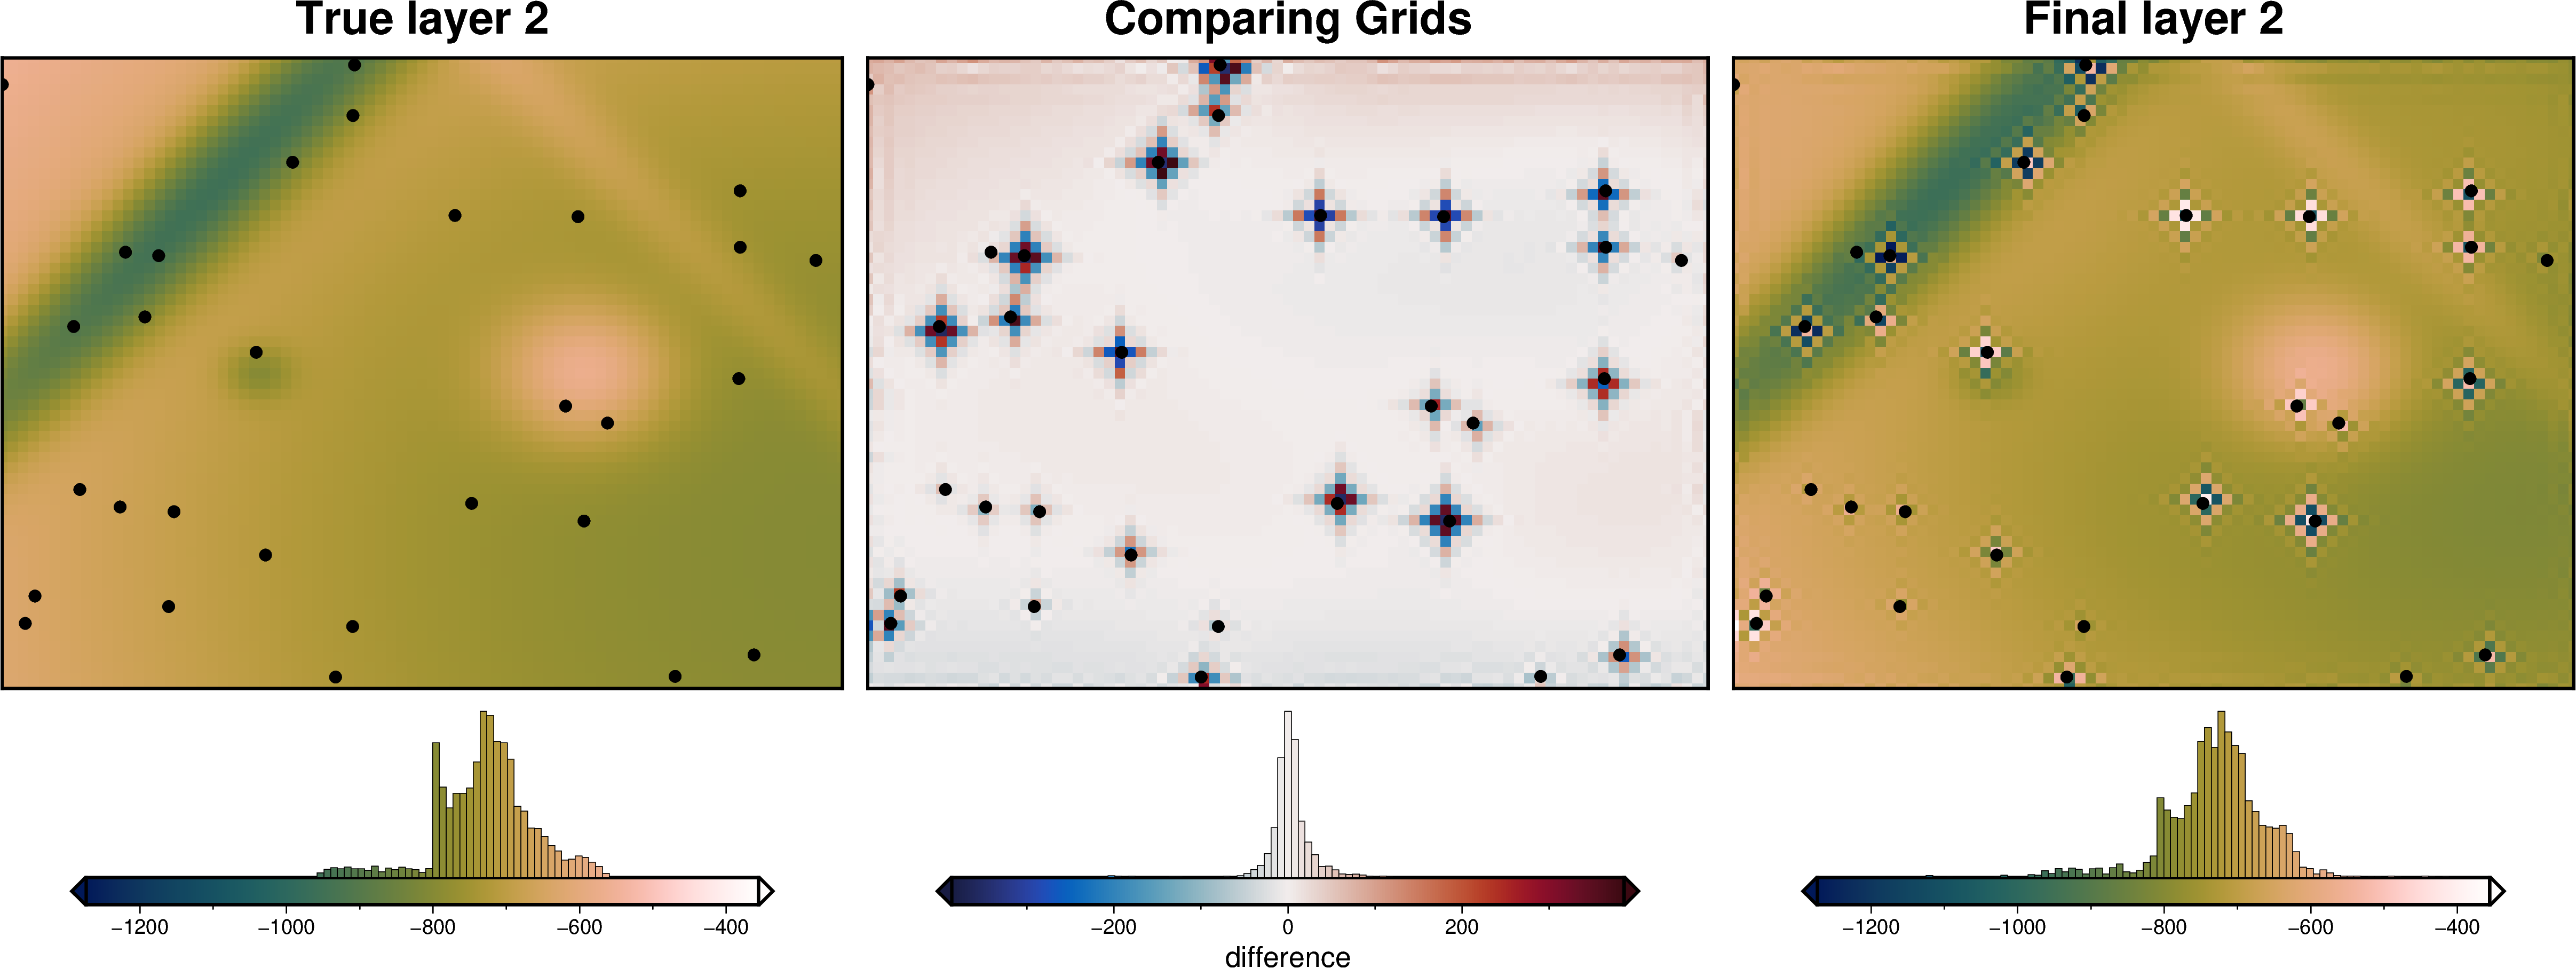

In [28]:
grids = utils.grd_compare(
    true_layer2,
    final_layer2_noise,
    grid1_name='True layer 2',
    grid2_name='Final layer 2',
    region=inversion_region,
    plot=True,
    plot_type="pygmt",
    cmap='batlowW',
    # cmap="gist_earth",
    robust=True,
    points=constraint_points,
    hist=True,
    inset=False,
)

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


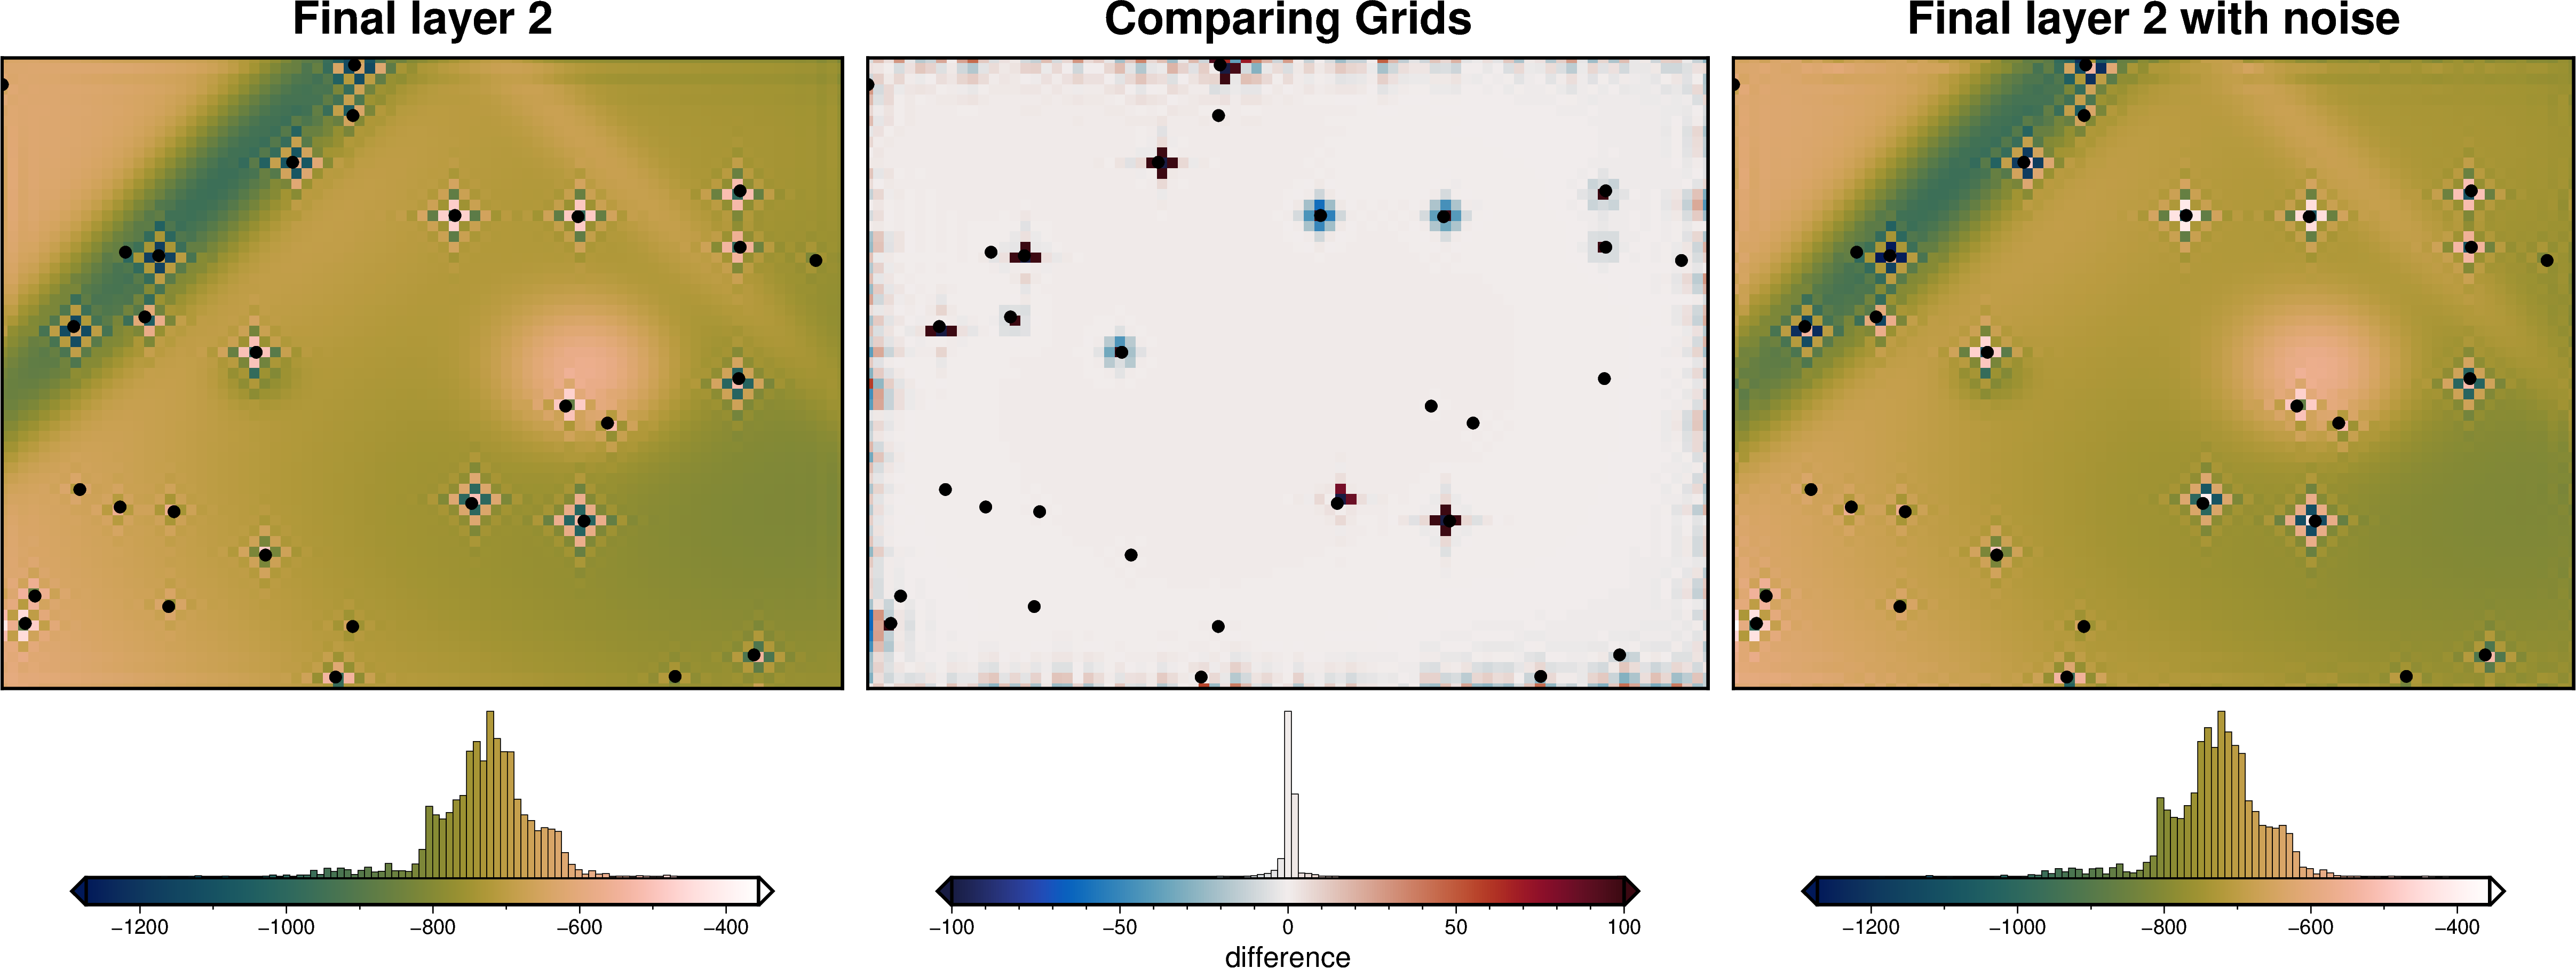

In [29]:
grids = utils.grd_compare(
    final_layer2,
    final_layer2_noise,
    grid1_name='Final layer 2',
    grid2_name='Final layer 2 with noise',
    region=inversion_region,
    plot=True,
    plot_type="pygmt",
    cmap='batlowW',
    # cmap="gist_earth",
    robust=True,
    points=constraint_points,
    hist=True,
    inset=False,
)